### Data Preprocessing

In [1]:
import torch
import torchvision
import torchinfo
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from shutil import copy  # Import shutil for high-level file operations
from shutil import rmtree, copytree
from pathlib import Path
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torchvision.transforms import ToTensor
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from collections import defaultdict
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

c:\Users\PC\anaconda3\envs\torch_gpuenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

## Loading and organize the Images by Category

**1. Reading and Processing Data:**

- Reads image paths and class information from the text file of the dataset meta.
- Builds a dictionary mapping class names to lists of image filenames.

**2. Organizing Images:**

- Iterates through each class:
    - Creates a folder for the class if it doesn't exist.
    - Copies images belonging to the class into the corresponding folder.

In [2]:
def prepare_the_data(data_txt_path, src, dest):
    classes = defaultdict(list)
    # data_txt_path = 'D:/Downloads/food101/food-101/meta/train.txt'
    # src = 'D:/Downloads/food101/food-101/images'
    # #target = 'D:/Downloads/food101_split'
    # dest = 'train'
    with open(data_txt_path, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]

    for i in paths:
        class_with_img = i.split('/')
        classes[class_with_img[0]].append(class_with_img[1] + '.jpg')

    for food_class in classes.keys():
        print(f'Copying the {food_class} class.. ')
        if not os.path.exists(os.path.join(dest, food_class)):
            os.makedirs(os.path.join(dest, food_class))
        for i in classes[food_class]:
            copy(os.path.join(src, food_class, i), os.path.join(dest, food_class, i))
        print(f'{food_class} is copied !')

In [3]:
# Prepare the Train data
prepare_the_data('D:/Downloads/food101/food-101/meta/train.txt', 'D:/Downloads/food101/food-101/images', 'train')

Copying the apple_pie class.. 
apple_pie is copied !
Copying the baby_back_ribs class.. 
baby_back_ribs is copied !
Copying the baklava class.. 
baklava is copied !
Copying the beef_carpaccio class.. 
beef_carpaccio is copied !
Copying the beef_tartare class.. 
beef_tartare is copied !
Copying the beet_salad class.. 
beet_salad is copied !
Copying the beignets class.. 
beignets is copied !
Copying the bibimbap class.. 
bibimbap is copied !
Copying the bread_pudding class.. 
bread_pudding is copied !
Copying the breakfast_burrito class.. 
breakfast_burrito is copied !
Copying the bruschetta class.. 
bruschetta is copied !
Copying the caesar_salad class.. 
caesar_salad is copied !
Copying the cannoli class.. 
cannoli is copied !
Copying the caprese_salad class.. 
caprese_salad is copied !
Copying the carrot_cake class.. 
carrot_cake is copied !
Copying the ceviche class.. 
ceviche is copied !
Copying the cheesecake class.. 
cheesecake is copied !
Copying the cheese_plate class.. 
cheese_

In [4]:
# Prepare the test data
prepare_the_data('D:/Downloads/food101/food-101/meta/test.txt', 'D:/Downloads/food101/food-101/images', 'test')

Copying the apple_pie class.. 
apple_pie is copied !
Copying the baby_back_ribs class.. 
baby_back_ribs is copied !
Copying the baklava class.. 
baklava is copied !
Copying the beef_carpaccio class.. 
beef_carpaccio is copied !
Copying the beef_tartare class.. 
beef_tartare is copied !
Copying the beet_salad class.. 
beet_salad is copied !
Copying the beignets class.. 
beignets is copied !
Copying the bibimbap class.. 
bibimbap is copied !
Copying the bread_pudding class.. 
bread_pudding is copied !
Copying the breakfast_burrito class.. 
breakfast_burrito is copied !
Copying the bruschetta class.. 
bruschetta is copied !
Copying the caesar_salad class.. 
caesar_salad is copied !
Copying the cannoli class.. 
cannoli is copied !
Copying the caprese_salad class.. 
caprese_salad is copied !
Copying the carrot_cake class.. 
carrot_cake is copied !
Copying the ceviche class.. 
ceviche is copied !
Copying the cheesecake class.. 
cheesecake is copied !
Copying the cheese_plate class.. 
cheese_

## Grabbing a Random Image

1. **Sets image path:** Stores the dataset directory in `image_path`.
2. **Lists images:** Uses `glob` to find all `.jpg` files recursively, storing paths in `images_path_list`. It then prints the total image count.
3. **Selects randomly:** Chooses a random image path from the list using `random.choice`.
4. **Loads image:** Opens the chosen image using `Image.open` and assigns it to `img`.

This snippet efficiently retrieves a random image for further processing.

length of our dataset images(Train and Test): 2250


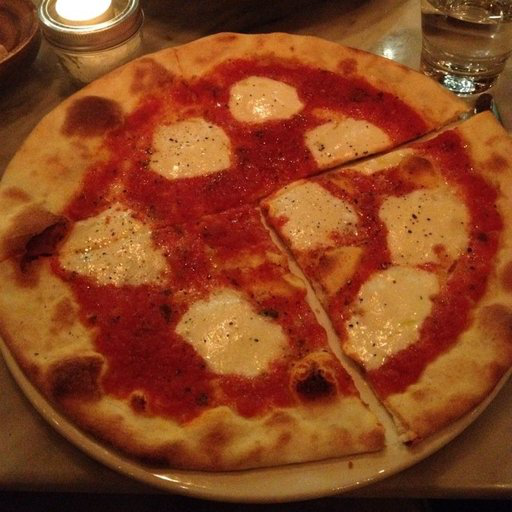

In [5]:
# Getting a random picture from our dataset
image_path = Path('D:/Downloads/food101_split/train_mini')
images_path_list = list(image_path.glob('*/*.jpg'))
print(f'length of our dataset images(Train and Test): {len(images_path_list)}')
random_img = random.choice(images_path_list)
img = Image.open(random_img)
img

In [58]:
os.chdir('D:/Downloads/food101_split')

In [59]:
# Define the train and test directories
train_dir = 'D:/Downloads/food101_split/train_mini'
test_dir = 'D:/Downloads/food101_split/test_mini'
image_path_list = list(Path('D:/Downloads/food101_split/train_mini').glob('*/*.jpg'))

In [6]:
os.chdir('D:/Downloads/food101_split')

## Creating a Mini Dataset

The `dataset_mini` function creates a smaller dataset from a larger one, focusing on specific items:

1. **Clean slate:** Checks and removes the destination directory if it exists, then creates it.
2. **Selective copying:** Iterates through each food item in the list:
    - Prints a message indicating the processing item.
    - Copies the entire directory structure (files and subfolders) for the item from source to destination.

In [60]:
def dataset_mini(food_list, src, dest):
    # Check if the destination directory exists
    if os.path.exists(dest):
        # If it exists, remove it to ensure a clean slate
        rmtree(dest)  # Removing dataset_mini (if it already exists) folders
    # Create the destination directory
    os.makedirs(dest)
    
    # Iterate over each food item in the provided list
    for food_item in food_list:
        print("Copying images into", food_item)
        # Recursively copy the images from the source directory to the destination directory for each food item
        copytree(os.path.join(src, food_item), os.path.join(dest, food_item))

In [61]:
# Choosing 5 classes from the dataset(101 classes)
food_list = ['apple_pie', 'pizza', 'omelette', 'steak', 'waffles']

# Source and destination directories for train and test datasets
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

# Create train_mini dataset
dataset_mini(food_list, src_train, dest_train)

# Create test_mini dataset
dataset_mini(food_list, src_test, dest_test)

Copying images into apple_pie
Copying images into pizza
Copying images into omelette
Copying images into steak
Copying images into waffles
Copying images into apple_pie
Copying images into pizza
Copying images into omelette
Copying images into steak
Copying images into waffles


## Data Transformations

**Training Transformations (`train_transforms_augmented`):**

1. **Random Order:** Applies a random sequence of the following transformations:
    - **AutoAugment:** Applies various image augmentations automatically.
    - **RandAugment:** Applies a specific set of image augmentations with randomness.
    - **TrivialAugmentWide:** Applies simple but effective image augmentations.
2. **Resize:** Resizes images to a fixed size (224x224) for model input.
3. **ToTensor:** Converts images to PyTorch tensors.
4. **Normalize:** Normalizes pixel values using mean and standard deviation.

**Testing Transformations (`test_transforms_simple`):**

1. **Resize:** Resizes images to match training input size (224x224).
2. **ToTensor:** Converts images to PyTorch tensors.
3. **Normalize:** Normalizes pixel values using the same mean and standard deviation as training.

This approach ensures consistent data preparation for both training (with augmentation) and testing (without augmentation).

In [62]:
# Transform the train and test data
train_transforms_augmented = transforms.Compose([
    transforms.RandomOrder((
        transforms.AutoAugment(),
        transforms.RandAugment(),
        transforms.TrivialAugmentWide()
    )),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms_simple = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


## Creating Datasets

Prepares datasets for training and testing:

1. **Concatenated Training Dataset:**
    - Combines two `ImageFolder` datasets using `ConcatDataset`.
    - One dataset uses `train_transforms_augmented` for data augmentation during training.
    - The other uses `test_transforms_simple` without augmentation.
2. **Testing Dataset:**
    - Creates an `ImageFolder` dataset for testing data using `test_transforms_simple`.
    - Disables target transformation (`target_transform=None`) as labels might not be needed for testing.

In [64]:
train_concated_dataset = torch.utils.data.ConcatDataset(
                                        datasets=[
                                        datasets.ImageFolder(train_dir,
                                        transform = train_transforms_augmented),
                                        datasets.ImageFolder(train_dir,
                                        transform = test_transforms_simple)])

test_data_folder = datasets.ImageFolder(test_dir,
                                        transform=test_transforms_simple,
                                        target_transform=None)


## Visualizing Transformed Images

**Function:**

- Randomly selects `n` images.
- Iterates, displaying original and transformed versions in a 2-subplot figure:
    - Original: displayed with size info, axes hidden.
    - Transformed: applied with `transform`, displayed with size info, axes hidden.
- Adds image class as a supertitle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


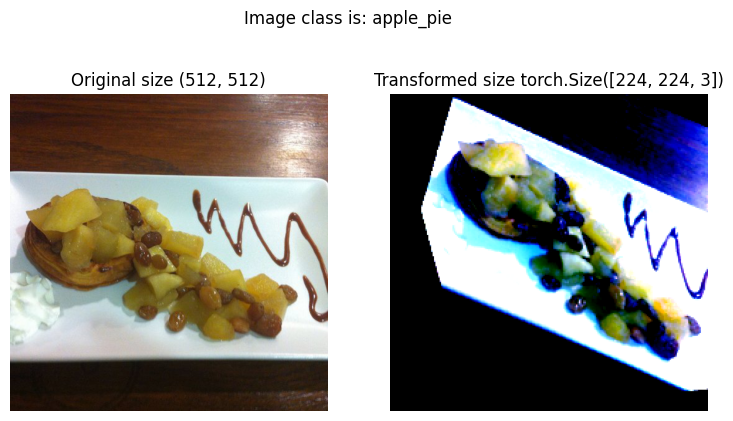

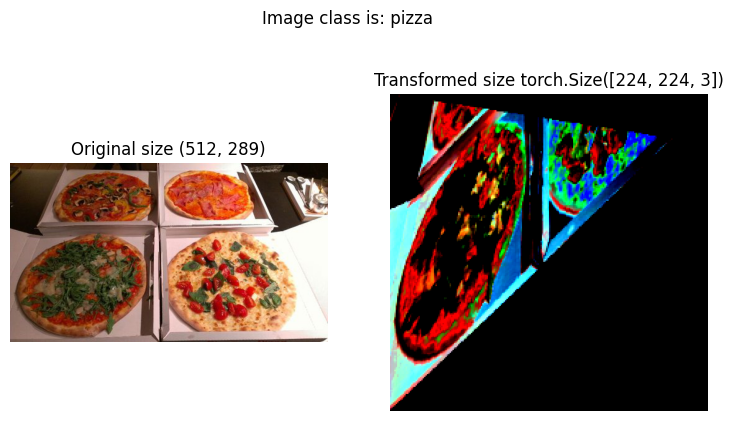

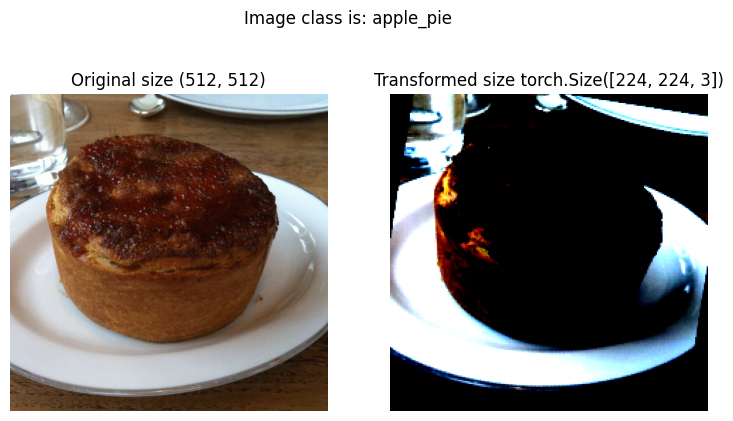

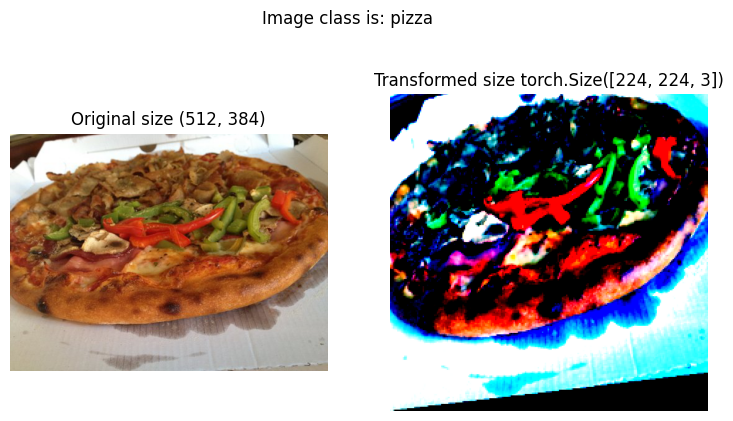

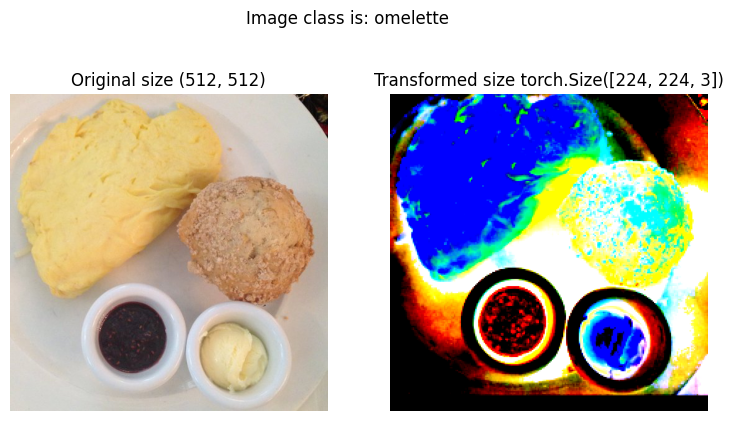

In [65]:
def plot_transformed_img(image_paths, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    random_img_paths = random.sample(image_paths, k=n)
    for image_path in random_img_paths:
        with Image.open(image_path, 'r') as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original size {f.size}')
            ax[0].axis(False);

            transformed_img = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_img)
            ax[1].set_title(f'Transformed size {transformed_img.shape}')
            ax[1].axis(False)
        fig.set_figheight(val=5)
        fig.set_figwidth(val=9)
        fig.suptitle(f"Image class is: {image_path.parent.stem}", fontsize=12, fontweight='normal')

plot_transformed_img(image_path_list, train_transforms_augmented, n=5)



Sets up `Dataloaders` for training and testing using PyTorch:

- **Batching:** `BATCH_SIZE` images are processed together (16 here) for efficiency.
- **Parallelism:** `NUM_WORKERS` CPU cores load data concurrently (utilizes all cores).
- **Shuffling:** Training data is shuffled for better generalization.
- **Class Information:** Class names (`data_classes`) and their corresponding indices (`classes_to_idx`) are stored.

Dataloaders streamline data loading, improving training and testing efficiency.


In [66]:
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_concated_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data_folder,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)

In [67]:
# Checking the shape of the train data
train_img, train_label = next(iter(train_dataloader))
train_img.shape, train_label.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [68]:
# Checking the number of bathces of each dataset (train and test)
len(train_dataloader), len(test_dataloader)

(469, 79)

In [69]:
data_classes = test_data_folder.classes
classes_to_idx = test_data_folder.class_to_idx
data_classes, classes_to_idx

(['apple_pie', 'omelette', 'pizza', 'steak', 'waffles'],
 {'apple_pie': 0, 'omelette': 1, 'pizza': 2, 'steak': 3, 'waffles': 4})

# Model Initialization

## VGG16 Model Definition with Explanations

This code defines a `VGG16` neural network architecture for image classification:

**Key Components:**

* **Convolutional Layers:** Extract features with filters (`Conv2d`).
* **Batch Normalization (`BatchNorm2d`)** Stabilizes training by normalizing activations across a batch, improving  convergence.
* **ReLU Activation:** Adds non-linearity (`ReLU()`).
* **Max Pooling (`MaxPool2d`)** Downsamples feature maps, preserving important features while reducing dimensionality.
* **Dense Layers (`Linear`)** Classify the extracted features.
* **Dropout** Prevents overfitting during training.

**Adaptability:** Output shape changes based on the specific dataset's classes.


![picture 0](../images/9901cc27a98891e0d30806b6570b055292b40893cb7fa43ec6ca59ef8ec655a3.png)  


In [70]:
class VGG16(nn.Module):
    def __init__(self, out_shape):
        super(VGG16, self).__init__()
        self.SHAPE_AFTER_FLATTEN = 7*7
        self.layer1 = nn.Sequential(
                 
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
            
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(self.SHAPE_AFTER_FLATTEN*512, 4096),
            nn.ReLU())
        
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        
        self.fc2= nn.Sequential(
            nn.Linear(4096, out_shape))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        # print(out.shape)
        # #out = out.reshape(out.size(0), -1)
        #print(out.shape)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        # print(out.shape)
        return out
model = VGG16(out_shape=len(classes_to_idx)).to(device)

## Loss Function, Optimizer & Scheduler

Define essential elements for training the model:

**Loss Function:**

* `loss_fn = nn.CrossEntropyLoss()`: Defines the loss function as cross-entropy for multi-class classification.

**Optimizer:**

* `optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)`: 
    - Uses Stochastic Gradient Descent (SGD) optimizer.
    - Sets the learning rate (`lr`) to 0.01.

**Learning Rate Scheduler:**

* `scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=35, gamma=0.1)`:
    - Implements a step-based learning rate scheduler.
    - Reduces the learning rate by a factor of 0.1 (`gamma`) every 35 epochs (`step_size`).

In [71]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= model.parameters(),
                             lr= 0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=35, gamma=0.1)

# Train the model

 **Training and Testing in PyTorch**

- **`train_step`:**
    - Trains model on a data batch.
    - Forward pass, loss calculation, backpropagation, parameter updates.
    - Tracks and returns average loss and accuracy.

- **`test_step`:**
    - Evaluates model on a data batch.
    - Forward pass, loss calculation, accuracy calculation.
    - No backpropagation, uses inference mode.
    - Tracks and returns average loss and accuracy.


In [72]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        
        # 5. Optimizer step
        optimizer.step()
        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        # if batch % 50 == 0 or batch == len(train_dataloader):
        #     print(f'{batch*BATCH_SIZE} / {len(train_dataloader) * BATCH_SIZE}')
    
    scheduler.step()

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [73]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## Custom Callback: Save Best Model

This code defines a `SaveBestModel` callback that saves the best performing model during training:

* Tracks the best validation loss and a waiting period.
* Saves the model, optimizer state, and epoch/test accuracy when a better validation loss is found (after waiting period).

This helps access the best model based on validation performance.

In [74]:
class SaveBestModel:
    def __init__(self, best_validation_loss = float('inf')):
        self.best_validation_loss = best_validation_loss
        self.EPOCH_PATIENCE = 20
    def __call__(self, current_validation_loss, current_test_acc, model, epoch, optimizer):
        if current_validation_loss < self.best_validation_loss and epoch > self.EPOCH_PATIENCE:
            # Prinitng the new loss
            print(f'Found new best test loss: {current_validation_loss} ...')
            self.best_validation_loss = current_validation_loss

            # Saving the model
            print(f'Saving the model... ')
            torch.save({
                'epoch' : epoch+1,
                'model_stat_dict' : model.state_dict(),
                'optimizer' : optimizer.state_dict()
            }, f'D:/Downloads/food101_split/trained_model/model{int(np.round((current_test_acc / 1) * 100))}.pth')
    
save_best_model = SaveBestModel()

## Early Stopping for Overfitting Prevention

This code implements `ValidationLossEarlyStopping` to prevent overfitting:

- **Initialization:** Sets parameters for patience (default 50 epochs) and minimum improvement threshold (default 0.0) for validation loss.

- **`early_stop_check`:** Tracks the best validation loss and a counter for non-improvement. Stops training if validation loss doesn't improve by the minimum threshold for the specified patience.

This technique helps prevent overfitting by stopping training when the model stops improving on the validation set.


In [75]:
class ValidationLossEarlyStopping:
    def __init__(self, patience=50):
        self.patience = patience  # number of times to allow for no improvement before stopping the execution
        self.counter = 0  # count the number of times the validation accuracy not improving
        self.min_validation_loss = np.inf
        self.early_stop = True

    # return True when validation loss is not decreased by the `min_delta` for `patience` times 
    def early_stop_check(self, validation_loss):
        if ((validation_loss) < self.min_validation_loss):
            self.min_validation_loss = validation_loss
            self.counter = 0  # reset the counter if validation loss decreased
        elif ((validation_loss) >= self.min_validation_loss):
            self.counter += 1 # increase the counter if validation loss is not decreased
            if self.counter > self.patience:
                self.early_stop = False
            else:
                self.early_stop = True

early_stop = ValidationLossEarlyStopping()

In [76]:
# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Checking the current test loss and save the model if it the best
        save_best_model(test_loss, test_acc, model, epoch, optimizer)

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Checking if there is no improvments for the last 50 epochs
        early_stop.early_stop_check(test_loss)

        if not early_stop.early_stop:
            print(f'No improvments for 50 epochs')
            break

    # 6. Return the filled results at the end of the epochs
    return results

In [77]:
model_results = train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=150)

  1%|          | 1/150 [23:43<58:55:50, 1423.83s/it]

Epoch: 1 | train_loss: 1.5118 | train_acc: 0.3414 | test_loss: 1.2348 | test_acc: 0.5095


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001AAE04C8430>
Traceback (most recent call last):
  File "c:\Users\PC\anaconda3\envs\torch_gpuenv\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "c:\Users\PC\anaconda3\envs\torch_gpuenv\lib\site-packages\torch\utils\data\dataloader.py", line 1424, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
  1%|▏         | 2/150 [46:24<57:00:36, 1386.73s/it]

Epoch: 2 | train_loss: 1.3792 | train_acc: 0.4286 | test_loss: 1.3049 | test_acc: 0.4889


  2%|▏         | 3/150 [54:04<39:21:00, 963.68s/it] 

Epoch: 3 | train_loss: 1.2846 | train_acc: 0.4857 | test_loss: 1.3235 | test_acc: 0.5253


  3%|▎         | 4/150 [1:01:45<31:01:28, 764.99s/it]

Epoch: 4 | train_loss: 1.2043 | train_acc: 0.5185 | test_loss: 1.8697 | test_acc: 0.4312


  3%|▎         | 5/150 [1:09:26<26:23:43, 655.33s/it]

Epoch: 5 | train_loss: 1.1565 | train_acc: 0.5414 | test_loss: 1.2459 | test_acc: 0.4842


  4%|▍         | 6/150 [1:17:07<23:34:18, 589.29s/it]

Epoch: 6 | train_loss: 1.0971 | train_acc: 0.5690 | test_loss: 1.0683 | test_acc: 0.5514


  5%|▍         | 7/150 [1:24:47<21:43:46, 547.04s/it]

Epoch: 7 | train_loss: 1.0550 | train_acc: 0.5840 | test_loss: 0.9678 | test_acc: 0.6535


  5%|▌         | 8/150 [1:32:27<20:29:13, 519.39s/it]

Epoch: 8 | train_loss: 1.0069 | train_acc: 0.6069 | test_loss: 0.7704 | test_acc: 0.7104


  6%|▌         | 9/150 [1:40:06<19:36:33, 500.67s/it]

Epoch: 9 | train_loss: 0.9835 | train_acc: 0.6143 | test_loss: 0.9242 | test_acc: 0.6638


  7%|▋         | 10/150 [1:47:46<18:58:38, 487.99s/it]

Epoch: 10 | train_loss: 0.9328 | train_acc: 0.6377 | test_loss: 0.6604 | test_acc: 0.7595


  7%|▋         | 11/150 [1:55:25<18:30:09, 479.20s/it]

Epoch: 11 | train_loss: 0.8951 | train_acc: 0.6489 | test_loss: 0.9858 | test_acc: 0.6131


  8%|▊         | 12/150 [2:03:05<18:08:17, 473.17s/it]

Epoch: 12 | train_loss: 0.8730 | train_acc: 0.6597 | test_loss: 0.6255 | test_acc: 0.7793


  9%|▊         | 13/150 [2:10:44<17:50:55, 469.02s/it]

Epoch: 13 | train_loss: 0.8349 | train_acc: 0.6817 | test_loss: 0.6371 | test_acc: 0.7729


  9%|▉         | 14/150 [2:18:24<17:36:32, 466.12s/it]

Epoch: 14 | train_loss: 0.7939 | train_acc: 0.6974 | test_loss: 0.6485 | test_acc: 0.7595


 10%|█         | 15/150 [2:26:03<17:24:10, 464.08s/it]

Epoch: 15 | train_loss: 0.7663 | train_acc: 0.7076 | test_loss: 1.0123 | test_acc: 0.6329


 11%|█         | 16/150 [2:33:42<17:13:20, 462.69s/it]

Epoch: 16 | train_loss: 0.7344 | train_acc: 0.7198 | test_loss: 0.5971 | test_acc: 0.7824


 11%|█▏        | 17/150 [2:41:22<17:03:34, 461.76s/it]

Epoch: 17 | train_loss: 0.6879 | train_acc: 0.7358 | test_loss: 0.6909 | test_acc: 0.7468


 12%|█▏        | 18/150 [2:49:01<16:54:20, 461.06s/it]

Epoch: 18 | train_loss: 0.6496 | train_acc: 0.7570 | test_loss: 0.6283 | test_acc: 0.7698


 13%|█▎        | 19/150 [2:56:41<16:45:34, 460.57s/it]

Epoch: 19 | train_loss: 0.6415 | train_acc: 0.7587 | test_loss: 1.2427 | test_acc: 0.6036


 13%|█▎        | 20/150 [3:04:20<16:37:11, 460.24s/it]

Epoch: 20 | train_loss: 0.6238 | train_acc: 0.7659 | test_loss: 0.8447 | test_acc: 0.6946


 14%|█▍        | 21/150 [3:12:00<16:29:06, 460.05s/it]

Epoch: 21 | train_loss: 0.5948 | train_acc: 0.7774 | test_loss: 0.7204 | test_acc: 0.7840
Epoch: 22 | train_loss: 0.5730 | train_acc: 0.7854 | test_loss: 0.5829 | test_acc: 0.7919
Found new best test loss: 0.58285085937079 ...
Saving the model... 


 15%|█▌        | 23/150 [3:27:24<16:15:16, 460.76s/it]

Epoch: 23 | train_loss: 0.5614 | train_acc: 0.7916 | test_loss: 0.8645 | test_acc: 0.7112


 16%|█▌        | 24/150 [3:35:03<16:06:37, 460.30s/it]

Epoch: 24 | train_loss: 0.5262 | train_acc: 0.8052 | test_loss: 0.6159 | test_acc: 0.8078


 17%|█▋        | 25/150 [3:42:42<15:58:23, 460.03s/it]

Epoch: 25 | train_loss: 0.4974 | train_acc: 0.8143 | test_loss: 0.7592 | test_acc: 0.7476


 17%|█▋        | 26/150 [3:50:22<15:50:21, 459.85s/it]

Epoch: 26 | train_loss: 0.4976 | train_acc: 0.8153 | test_loss: 0.8527 | test_acc: 0.7191


 18%|█▊        | 27/150 [3:58:01<15:42:17, 459.66s/it]

Epoch: 27 | train_loss: 0.4794 | train_acc: 0.8247 | test_loss: 0.6931 | test_acc: 0.7753


 19%|█▊        | 28/150 [4:05:40<15:34:29, 459.59s/it]

Epoch: 28 | train_loss: 0.4653 | train_acc: 0.8306 | test_loss: 0.6254 | test_acc: 0.7872


 19%|█▉        | 29/150 [4:13:20<15:26:44, 459.54s/it]

Epoch: 29 | train_loss: 0.4447 | train_acc: 0.8363 | test_loss: 1.3817 | test_acc: 0.7057


 20%|██        | 30/150 [4:20:59<15:19:02, 459.52s/it]

Epoch: 30 | train_loss: 0.4375 | train_acc: 0.8436 | test_loss: 0.6796 | test_acc: 0.7824


 21%|██        | 31/150 [4:28:39<15:11:18, 459.48s/it]

Epoch: 31 | train_loss: 0.4162 | train_acc: 0.8455 | test_loss: 0.8974 | test_acc: 0.7587
Epoch: 32 | train_loss: 0.4121 | train_acc: 0.8483 | test_loss: 0.5214 | test_acc: 0.8180
Found new best test loss: 0.5213757563924676 ...
Saving the model... 


 22%|██▏       | 33/150 [4:44:02<14:57:55, 460.47s/it]

Epoch: 33 | train_loss: 0.4031 | train_acc: 0.8515 | test_loss: 0.5687 | test_acc: 0.8157


 23%|██▎       | 34/150 [4:51:42<14:49:33, 460.11s/it]

Epoch: 34 | train_loss: 0.4015 | train_acc: 0.8543 | test_loss: 0.7179 | test_acc: 0.7508


 23%|██▎       | 35/150 [4:59:21<14:41:20, 459.83s/it]

Epoch: 35 | train_loss: 0.3868 | train_acc: 0.8609 | test_loss: 0.6348 | test_acc: 0.7998
Epoch: 36 | train_loss: 0.2957 | train_acc: 0.8945 | test_loss: 0.4711 | test_acc: 0.8521
Found new best test loss: 0.4711448220724735 ...
Saving the model... 


 25%|██▍       | 37/150 [5:14:46<14:28:16, 461.03s/it]

Epoch: 37 | train_loss: 0.2869 | train_acc: 0.8956 | test_loss: 0.4713 | test_acc: 0.8521


 25%|██▌       | 38/150 [5:22:30<14:22:27, 462.03s/it]

Epoch: 38 | train_loss: 0.2712 | train_acc: 0.8985 | test_loss: 0.4801 | test_acc: 0.8552


 26%|██▌       | 39/150 [5:30:11<14:13:58, 461.61s/it]

Epoch: 39 | train_loss: 0.2528 | train_acc: 0.9091 | test_loss: 0.4785 | test_acc: 0.8536
Epoch: 40 | train_loss: 0.2434 | train_acc: 0.9127 | test_loss: 0.4691 | test_acc: 0.8608
Found new best test loss: 0.46910437900879526 ...
Saving the model... 


 27%|██▋       | 41/150 [5:45:41<14:01:45, 463.36s/it]

Epoch: 41 | train_loss: 0.2465 | train_acc: 0.9072 | test_loss: 0.4698 | test_acc: 0.8560


 28%|██▊       | 42/150 [5:53:26<13:54:51, 463.81s/it]

Epoch: 42 | train_loss: 0.2432 | train_acc: 0.9121 | test_loss: 0.4711 | test_acc: 0.8505


 29%|██▊       | 43/150 [6:01:11<13:47:34, 464.06s/it]

Epoch: 43 | train_loss: 0.2422 | train_acc: 0.9121 | test_loss: 0.4713 | test_acc: 0.8584


 29%|██▉       | 44/150 [6:08:55<13:40:05, 464.20s/it]

Epoch: 44 | train_loss: 0.2493 | train_acc: 0.9085 | test_loss: 0.4826 | test_acc: 0.8544


 30%|███       | 45/150 [6:16:39<13:32:20, 464.19s/it]

Epoch: 45 | train_loss: 0.2429 | train_acc: 0.9109 | test_loss: 0.4715 | test_acc: 0.8608
Epoch: 46 | train_loss: 0.2300 | train_acc: 0.9171 | test_loss: 0.4209 | test_acc: 0.8655
Found new best test loss: 0.42094281427798014 ...
Saving the model... 


 31%|███▏      | 47/150 [6:32:12<13:18:33, 465.18s/it]

Epoch: 47 | train_loss: 0.2434 | train_acc: 0.9125 | test_loss: 0.4717 | test_acc: 0.8536


 32%|███▏      | 48/150 [6:39:56<13:10:04, 464.75s/it]

Epoch: 48 | train_loss: 0.2372 | train_acc: 0.9151 | test_loss: 0.4618 | test_acc: 0.8639


 33%|███▎      | 49/150 [6:47:41<13:02:08, 464.64s/it]

Epoch: 49 | train_loss: 0.2383 | train_acc: 0.9155 | test_loss: 0.4577 | test_acc: 0.8639


 33%|███▎      | 50/150 [6:55:24<12:53:56, 464.36s/it]

Epoch: 50 | train_loss: 0.2319 | train_acc: 0.9118 | test_loss: 0.4507 | test_acc: 0.8639


 34%|███▍      | 51/150 [7:03:09<12:46:17, 464.42s/it]

Epoch: 51 | train_loss: 0.2333 | train_acc: 0.9159 | test_loss: 0.4697 | test_acc: 0.8679


 35%|███▍      | 52/150 [7:10:54<12:38:51, 464.61s/it]

Epoch: 52 | train_loss: 0.2290 | train_acc: 0.9139 | test_loss: 0.4895 | test_acc: 0.8544


 35%|███▌      | 53/150 [7:18:38<12:30:48, 464.42s/it]

Epoch: 53 | train_loss: 0.2178 | train_acc: 0.9205 | test_loss: 0.4753 | test_acc: 0.8552


 36%|███▌      | 54/150 [7:26:22<12:23:03, 464.41s/it]

Epoch: 54 | train_loss: 0.2186 | train_acc: 0.9209 | test_loss: 0.4769 | test_acc: 0.8623


 37%|███▋      | 55/150 [7:34:02<12:13:13, 463.09s/it]

Epoch: 55 | train_loss: 0.2278 | train_acc: 0.9174 | test_loss: 0.4659 | test_acc: 0.8616


 37%|███▋      | 56/150 [7:41:42<12:03:51, 462.04s/it]

Epoch: 56 | train_loss: 0.2054 | train_acc: 0.9249 | test_loss: 0.4846 | test_acc: 0.8623


 38%|███▊      | 57/150 [7:49:22<11:55:07, 461.37s/it]

Epoch: 57 | train_loss: 0.2147 | train_acc: 0.9232 | test_loss: 0.4773 | test_acc: 0.8631


 39%|███▊      | 58/150 [7:57:01<11:46:42, 460.90s/it]

Epoch: 58 | train_loss: 0.2048 | train_acc: 0.9254 | test_loss: 0.4790 | test_acc: 0.8576


 39%|███▉      | 59/150 [8:04:41<11:38:27, 460.52s/it]

Epoch: 59 | train_loss: 0.2113 | train_acc: 0.9249 | test_loss: 0.4556 | test_acc: 0.8679


 40%|████      | 60/150 [8:12:21<11:30:22, 460.25s/it]

Epoch: 60 | train_loss: 0.2090 | train_acc: 0.9277 | test_loss: 0.4605 | test_acc: 0.8623


 41%|████      | 61/150 [8:20:00<11:22:26, 460.07s/it]

Epoch: 61 | train_loss: 0.2044 | train_acc: 0.9257 | test_loss: 0.4662 | test_acc: 0.8631


 41%|████▏     | 62/150 [8:27:40<11:14:27, 459.86s/it]

Epoch: 62 | train_loss: 0.2040 | train_acc: 0.9282 | test_loss: 0.4932 | test_acc: 0.8568


 42%|████▏     | 63/150 [8:35:19<11:06:20, 459.55s/it]

Epoch: 63 | train_loss: 0.2165 | train_acc: 0.9207 | test_loss: 0.4704 | test_acc: 0.8655


 43%|████▎     | 64/150 [8:42:57<10:58:22, 459.33s/it]

Epoch: 64 | train_loss: 0.2101 | train_acc: 0.9267 | test_loss: 0.4746 | test_acc: 0.8631


 43%|████▎     | 65/150 [8:50:36<10:50:29, 459.18s/it]

Epoch: 65 | train_loss: 0.2112 | train_acc: 0.9244 | test_loss: 0.4688 | test_acc: 0.8616


 44%|████▍     | 66/150 [8:58:15<10:42:40, 459.05s/it]

Epoch: 66 | train_loss: 0.2094 | train_acc: 0.9228 | test_loss: 0.4799 | test_acc: 0.8616


 45%|████▍     | 67/150 [9:05:54<10:34:55, 458.98s/it]

Epoch: 67 | train_loss: 0.2028 | train_acc: 0.9290 | test_loss: 0.4937 | test_acc: 0.8616


 45%|████▌     | 68/150 [9:13:33<10:27:12, 458.93s/it]

Epoch: 68 | train_loss: 0.2068 | train_acc: 0.9267 | test_loss: 0.5035 | test_acc: 0.8560


 46%|████▌     | 69/150 [9:21:11<10:19:30, 458.89s/it]

Epoch: 69 | train_loss: 0.2079 | train_acc: 0.9243 | test_loss: 0.4712 | test_acc: 0.8600


 47%|████▋     | 70/150 [9:28:50<10:11:50, 458.88s/it]

Epoch: 70 | train_loss: 0.2024 | train_acc: 0.9264 | test_loss: 0.4507 | test_acc: 0.8608


 47%|████▋     | 71/150 [9:36:29<10:04:10, 458.87s/it]

Epoch: 71 | train_loss: 0.1916 | train_acc: 0.9293 | test_loss: 0.4415 | test_acc: 0.8671


 48%|████▊     | 72/150 [9:44:08<9:56:29, 458.83s/it] 

Epoch: 72 | train_loss: 0.1912 | train_acc: 0.9297 | test_loss: 0.4407 | test_acc: 0.8710


 49%|████▊     | 73/150 [9:51:47<9:48:52, 458.87s/it]

Epoch: 73 | train_loss: 0.1963 | train_acc: 0.9290 | test_loss: 0.4490 | test_acc: 0.8703


 49%|████▉     | 74/150 [9:59:25<9:41:07, 458.78s/it]

Epoch: 74 | train_loss: 0.1776 | train_acc: 0.9346 | test_loss: 0.4427 | test_acc: 0.8663


 50%|█████     | 75/150 [10:07:04<9:33:25, 458.74s/it]

Epoch: 75 | train_loss: 0.1946 | train_acc: 0.9296 | test_loss: 0.4472 | test_acc: 0.8671


 51%|█████     | 76/150 [10:14:48<9:27:51, 460.43s/it]

Epoch: 76 | train_loss: 0.1842 | train_acc: 0.9347 | test_loss: 0.4524 | test_acc: 0.8687


 51%|█████▏    | 77/150 [10:22:28<9:19:48, 460.11s/it]

Epoch: 77 | train_loss: 0.1916 | train_acc: 0.9299 | test_loss: 0.4458 | test_acc: 0.8639


 52%|█████▏    | 78/150 [10:30:07<9:11:53, 459.91s/it]

Epoch: 78 | train_loss: 0.1892 | train_acc: 0.9336 | test_loss: 0.4560 | test_acc: 0.8663


 53%|█████▎    | 79/150 [10:37:47<9:04:02, 459.75s/it]

Epoch: 79 | train_loss: 0.1942 | train_acc: 0.9303 | test_loss: 0.4597 | test_acc: 0.8703


 53%|█████▎    | 80/150 [10:45:26<8:56:16, 459.67s/it]

Epoch: 80 | train_loss: 0.1865 | train_acc: 0.9327 | test_loss: 0.4478 | test_acc: 0.8718


 54%|█████▍    | 81/150 [10:53:06<8:48:35, 459.65s/it]

Epoch: 81 | train_loss: 0.1892 | train_acc: 0.9343 | test_loss: 0.4584 | test_acc: 0.8679


 55%|█████▍    | 82/150 [11:00:48<8:41:50, 460.45s/it]

Epoch: 82 | train_loss: 0.1884 | train_acc: 0.9348 | test_loss: 0.4529 | test_acc: 0.8687


 55%|█████▌    | 83/150 [11:08:29<8:34:17, 460.55s/it]

Epoch: 83 | train_loss: 0.1879 | train_acc: 0.9302 | test_loss: 0.4653 | test_acc: 0.8623


 56%|█████▌    | 84/150 [11:16:12<8:27:29, 461.36s/it]

Epoch: 84 | train_loss: 0.1960 | train_acc: 0.9293 | test_loss: 0.4652 | test_acc: 0.8647


 57%|█████▋    | 85/150 [11:23:52<8:19:22, 460.97s/it]

Epoch: 85 | train_loss: 0.1813 | train_acc: 0.9354 | test_loss: 0.4630 | test_acc: 0.8679


 57%|█████▋    | 86/150 [11:31:35<8:12:10, 461.42s/it]

Epoch: 86 | train_loss: 0.1893 | train_acc: 0.9295 | test_loss: 0.4632 | test_acc: 0.8679


 58%|█████▊    | 87/150 [11:39:14<8:03:56, 460.90s/it]

Epoch: 87 | train_loss: 0.1758 | train_acc: 0.9363 | test_loss: 0.4556 | test_acc: 0.8671


 59%|█████▊    | 88/150 [11:46:57<7:56:49, 461.44s/it]

Epoch: 88 | train_loss: 0.1858 | train_acc: 0.9335 | test_loss: 0.4567 | test_acc: 0.8647


 59%|█████▉    | 89/150 [11:54:36<7:48:31, 460.85s/it]

Epoch: 89 | train_loss: 0.1922 | train_acc: 0.9303 | test_loss: 0.4523 | test_acc: 0.8655


 60%|██████    | 90/150 [12:02:19<7:41:22, 461.37s/it]

Epoch: 90 | train_loss: 0.1867 | train_acc: 0.9359 | test_loss: 0.4598 | test_acc: 0.8631


 61%|██████    | 91/150 [12:09:58<7:33:07, 460.80s/it]

Epoch: 91 | train_loss: 0.1872 | train_acc: 0.9331 | test_loss: 0.4625 | test_acc: 0.8655


 61%|██████▏   | 92/150 [12:17:46<7:27:19, 462.75s/it]

Epoch: 92 | train_loss: 0.1789 | train_acc: 0.9360 | test_loss: 0.4463 | test_acc: 0.8687


 62%|██████▏   | 93/150 [12:25:24<7:18:27, 461.54s/it]

Epoch: 93 | train_loss: 0.1807 | train_acc: 0.9343 | test_loss: 0.4678 | test_acc: 0.8631


 63%|██████▎   | 94/150 [12:33:04<7:10:05, 460.81s/it]

Epoch: 94 | train_loss: 0.1833 | train_acc: 0.9320 | test_loss: 0.4639 | test_acc: 0.8663


 63%|██████▎   | 95/150 [12:40:42<7:01:52, 460.22s/it]

Epoch: 95 | train_loss: 0.1940 | train_acc: 0.9298 | test_loss: 0.4556 | test_acc: 0.8671


 64%|██████▍   | 96/150 [12:48:25<6:54:48, 460.90s/it]

Epoch: 96 | train_loss: 0.1935 | train_acc: 0.9307 | test_loss: 0.4555 | test_acc: 0.8663


 64%|██████▍   | 96/150 [12:56:07<7:16:34, 485.08s/it]

Epoch: 97 | train_loss: 0.1685 | train_acc: 0.9394 | test_loss: 0.4584 | test_acc: 0.8639
No improvments for 50 epochs


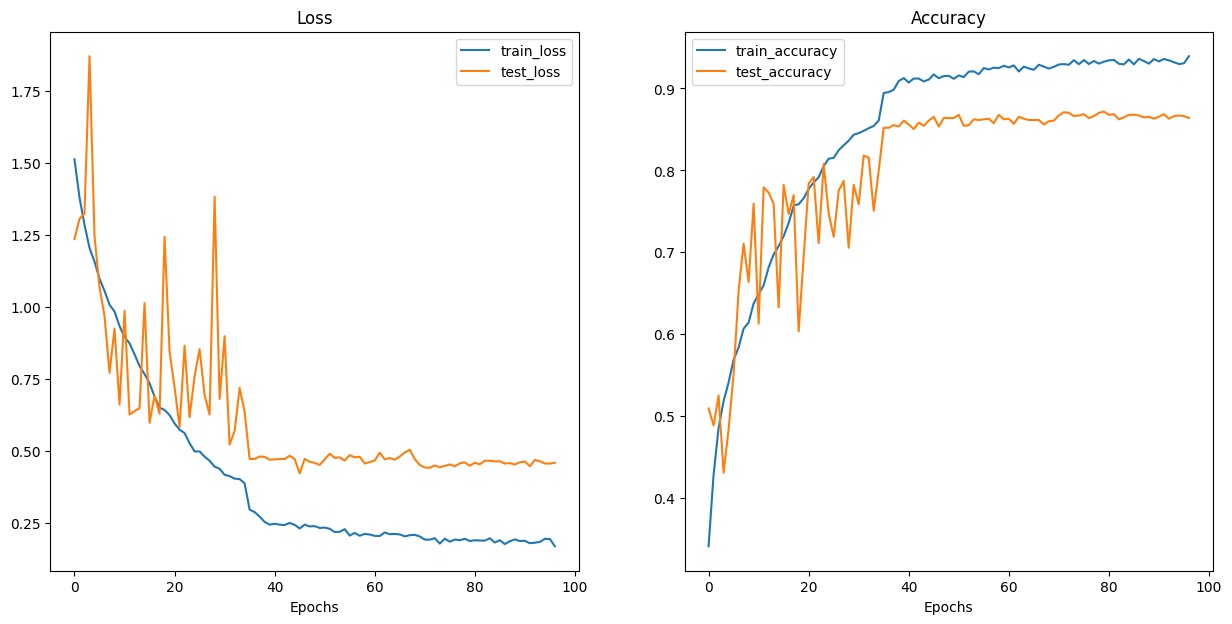

In [78]:
def plot_loss_curves(results):

    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(model_results)

## Test the model with a random image from the internet

In [88]:
raw_img = Image.open('D:/Downloads/food101_split/test_one/pizza/pizza.jpg')
test_one_dir = Path('D:/Downloads/food101_split/test_one')

## `test_custom_images`: Predict Class of Custom Images

This function predicts the class of an image from a user-provided path.

1. **Prepares dataset and dataloader:** Creates an `ImageFolder` dataset with `test_transforms_simple` and a dataloader.
2. **Extracts sample:** Gets one image and its label, printing their shapes.
3. **Predicts in inference mode:** Iterates through batches, moves data to device, predicts labels, and retrieves class name using `data_classes`.


In [86]:
def test_custom_images(model, path):
    test_one_folder = datasets.ImageFolder(path, transform=test_transforms_simple)
    test_one_dataloader = DataLoader(test_one_folder)
    one_img, one_label = next(iter(test_one_dataloader))
    one_img.shape, one_label.shape
    with torch.inference_mode():
        # Loop through DataLoader batches
        for img, label in test_one_dataloader:
            # Send data to target device
            img, label = img.to(device),label.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(img)
            test_pred_labels = test_pred_logits.argmax(dim=1)

    print(f'The class of the test image is {data_classes[test_pred_labels.item()]}')


The class of the test image is pizza


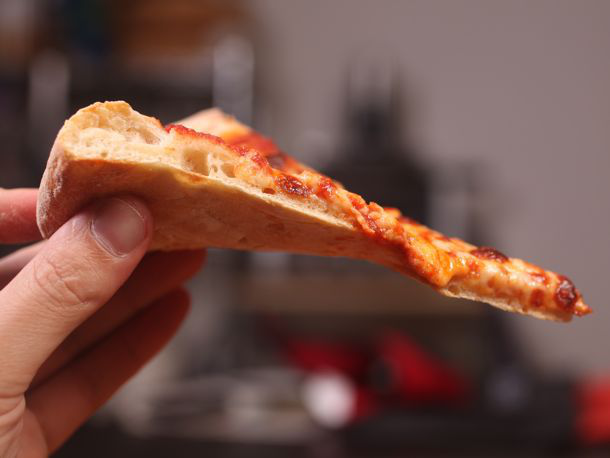

In [89]:
test_custom_images(model=model, path=test_one_dir)
raw_img

## Saving the Model

In [ ]:
# path_of_model = f'D:/Downloads/food101_split/trained_model/model84.pt'
# torch.save(model.state_dict(), path_of_model)